<a href="https://colab.research.google.com/github/thiakx/ModernRecSys/blob/master/COVID_19_Case_Study_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note that this notebook is meant as a proof-of-concept on of how we can apply the same framework on different image data. This work is not meant as medical research nor representative of how we can use CNN to detect COVID-19.

For this notebook, we will walk through the steps needed to identify x-rays with COVID-19 and cluster the images using Approximate Nearest Neighbors. This is an extension of the Convolutional Neural Networks Recommender notebook and will follow the identical steps: 
1.   Convert images to embeddings
2.   Conduct Transfer Learning from ResNet
3.   Use Fastai hooks to retrieve image embeddings from step 2
4.   Use Approximate Nearest Neighbors to obtain most similar images based on the embeddings from step 3.

# Initial Setup

In [0]:
# #references: 
# #https://blog.usejournal.com/fastai-image-similarity-search-pytorch-hooks-spotifys-annoy-9161bf517aaf
# #https://towardsdatascience.com/similar-images-recommendations-using-fastai-and-annoy-16d6ceb3b809

# # install fastai for the hook and annoy for approximate nearest neighbors 
# !pip install fastai
# !pip install annoy
# !pip install gdown

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
from sklearn.model_selection import train_test_split
%matplotlib inline


In [0]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Sun Mar 22 16:01:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                    

## Get COVID-19 Data

COVID-19 data set: 
- Joseph Cohen from University of Montreal: https://github.com/ieee8023/covid-chestxray-dataset
- Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [0]:
# get the meta data
url = 'https://drive.google.com/uc?id=1FzYDR37ARMonfFFDpSFD8-ElB0UAChTr'
output = 'metadata.csv'
gdown.download(url, output, quiet=False)

# get the images
root_path = './'
url = 'https://drive.google.com/uc?id=1xgNzkM-TaiCQlJsaes_rBxbCElcaSN2D'
output = 'images.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile("images.zip","r") as zip_ref:
    zip_ref.extractall(root_path)

Downloading...
From: https://drive.google.com/uc?id=1FzYDR37ARMonfFFDpSFD8-ElB0UAChTr
To: /content/metadata.csv
100%|██████████| 78.8k/78.8k [00:00<00:00, 54.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xgNzkM-TaiCQlJsaes_rBxbCElcaSN2D
To: /content/images.zip
952MB [00:03, 244MB/s]


In [0]:
data_df = pd.read_csv('metadata.csv')
data_df['images'] = 'images/'+data_df['images']  

In [0]:
data_df[['images','category']].groupby('category').count()

images
category             
ARDS                4
COVID-19          124
No Finding       1585
Pneumocystis        2
SARS               11
Streptococcus       6

In [0]:
# As there are less than 25 samples  of ARDS, Pneumocystis, SARS & Streptococcus in total,
# I decided to remove those samples and  only keep COVID and healthy samples.
data_df = data_df[(data_df.category=='COVID-19') | (data_df.category=='No Finding')]

In [0]:
data_df[['images','category','category_label']].groupby(['category','category_label']).count()

images
category   category_label        
COVID-19   CT                  22
           X-ray              102
No Finding CT                   1
           X-ray             1584

In [0]:
# Exclude CT scans as the numbers are low and we only have 1 CT scan with no finding. 
data_df = data_df[(data_df.category_label!='CT')]

In [0]:
random_seed=12121212
train, test = train_test_split(data_df.copy(), test_size=0.2, stratify=data_df.category,random_state=random_seed)
test, val = train_test_split(test, test_size=0.5, stratify=test.category,random_state=random_seed)
train['dataset'] = 'train'
test['dataset'] = 'test'
val['dataset'] = 'val'
data_df = train.append(test).append(val).reset_index(drop=True)
print(len(data_df))
data_df.head()

1686


images  ... dataset
0                  images/NORMAL2-IM-0923-0001.jpeg  ...   train
1                  images/NORMAL2-IM-0351-0001.jpeg  ...   train
2  images/1-s2.0-S1684118220300608-main.pdf-002.jpg  ...   train
3                          images/IM-0490-0001.jpeg  ...   train
4                  images/NORMAL2-IM-1131-0001.jpeg  ...   train

[5 rows x 6 columns]

In [0]:
data_df[['images','category']].groupby('category').count()

images
category          
COVID-19       102
No Finding    1584

In [0]:
data_df[['images','location']].groupby('location').count()

images
location                                                  
Canada                                                   1
Changhua Christian Hospital, Changhua City, Tai...       2
China                                                    3
Hospital of Wuhan University, Wuhan, China               5
Italy                                                   41
Jiangxi Provincial People's Hospital, Nanchang,...       1
Jinling Hospital, Medical School of Nanjing Uni...       1
Jönköping, Sweden                                        2
Laniado Hospital, Netanya, Israel                        1
Macao, China                                             1
Myongji Hospital, Goyang, Korea                          3
Ospedale Santo Spirito. Rome, Italy                      3
Riccione, Italy                                          2
Sichuan Provincial People?? Hospital, Chengdu, ...       1
Snohomish County, Washington, USA                        7
Taiwan                                                   6
Taoyuan General Hospital, Taoyuan, Taiwan                4
Thanh Hóa, Vietnam                                       2
The Royal Melbourne Hospital, Melbourne, Australia       2
Tongji Medical College, Wuhan, Hubei Province, ...       1

In [0]:
data_df[['images','survival']].groupby('survival').count()

images
survival        
N              4
Y             41

# Convert images to embeddings

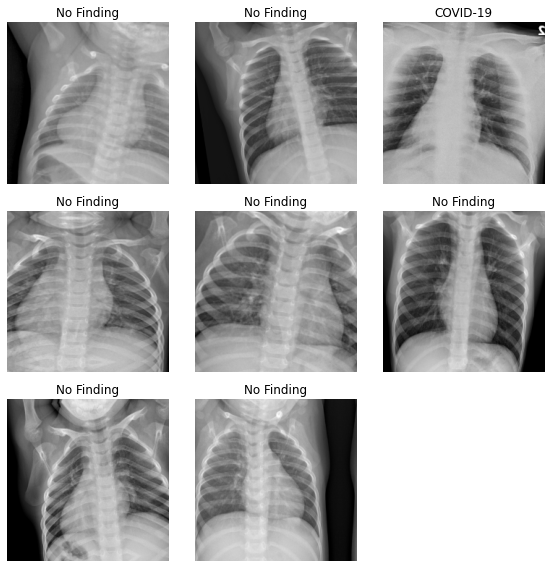

In [0]:
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='images').split_by_idxs(
    (data_df[data_df['dataset']=='train'].index),
    (data_df[data_df['dataset']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset'] == 'test'], path=root_path, cols='images')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=8).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

# Conduct Transfer Learning from ResNet

## Resnet18

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 2.51E-02


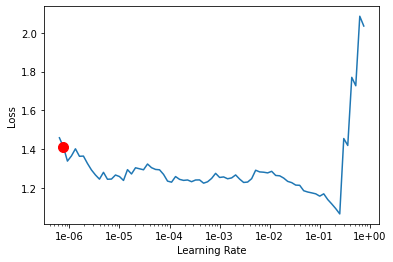

In [0]:
# see models available: https://docs.fast.ai/vision.models.html
# many options for Resnet, the numbers are the number of layers. 
# More layers are generally more accurate but take longer to train: resnet18, resnet34, resnet50, resnet101, resnet152
# get top 1 and top 5 accuracy
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

pretrained_model = models.resnet152
model_metrics = [accuracy, Precision(), Recall()]
learner = train_model(data, pretrained_model, model_metrics)

In [0]:
learner.fit_one_cycle(10, max_lr=1e-02)

## Evaluate Model 

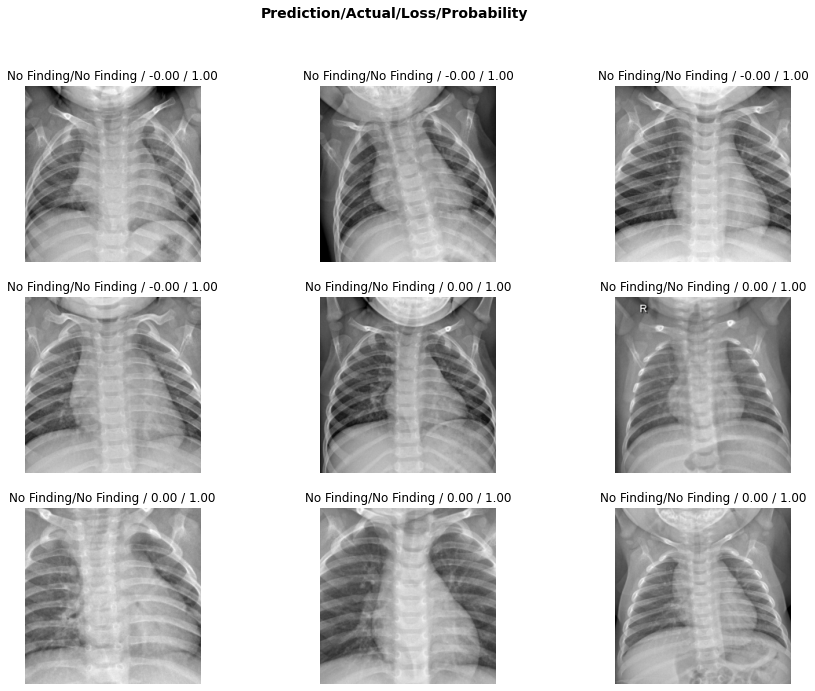

In [0]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

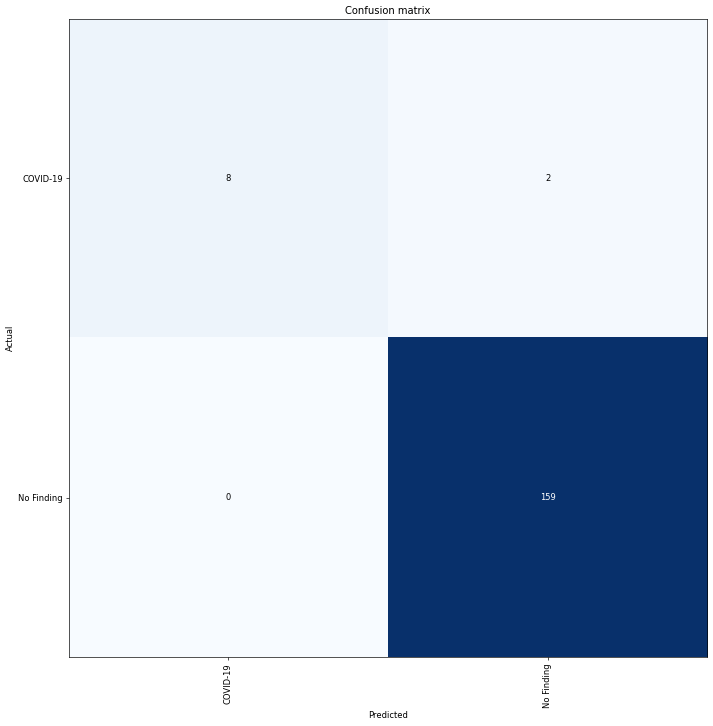

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
# saving the model (temporary, will lose model once environment resets)
learner.save('resnet152-covid19')

In [0]:
# saving the model (permanent), need to enter authorization code
drive.mount('/content/gdrive')
learner.save('/content/gdrive/My Drive/resnet152-covid19')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# view model details
learner.model.module

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

# Use Fastai hooks to retrieve image embeddings

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [0]:
# load the trained model
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

pretrained_model = models.resnet152
model_metrics = [accuracy, Precision(), Recall()]
model_path = "/content/gdrive/My Drive/resnet152-covid19"
learner = load_learner(data, pretrained_model, model_metrics, model_path)

In [0]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [0]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

img_path  ...                                         embeddings
0                    ./images/NORMAL2-IM-0923-0001.jpeg  ...  [145.60171508789062, 87.99614715576172, 130.14...
1                    ./images/NORMAL2-IM-0351-0001.jpeg  ...  [122.21405029296875, 80.22015380859375, 96.763...
2     ./images/1-s2.0-S1684118220300608-main.pdf-002...  ...  [157.9345703125, 185.4528350830078, 9.06208705...
3                            ./images/IM-0490-0001.jpeg  ...  [-71.12464904785156, -48.03896713256836, -57.0...
4                    ./images/NORMAL2-IM-1131-0001.jpeg  ...  [29.24832534790039, 22.005130767822266, 1.4590...
...                                                 ...  ...                                                ...
1512                 ./images/NORMAL2-IM-1005-0001.jpeg  ...  [65.26011657714844, 40.87766647338867, 40.2770...
1513                 ./images/NORMAL2-IM-0330-0001.jpeg  ...  [-401.5375671386719, -352.4116516113281, -432....
1514                 ./images/NORMAL2-IM-1178-0001.jpeg  ...  [-44.146522521972656, -51.56002426147461, -31....
1515            ./images/NORMAL2-IM-0983-0001-0002.jpeg  ...  [-17.467241287231445, -9.210673332214355, -45....
1516                 ./images/NORMAL2-IM-0453-0001.jpeg  ...  [-82.48481750488281, -56.121952056884766, -91....

[1517 rows x 4 columns]

# Use Approximate Nearest Neighbors to obtain most similar images

In [0]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 

def show_similar_images(similar_images_df):
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                 [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']])

# more tree = better approximation
ntree = 100
#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

# get additional cols for analysis
additional_cols = data_df[['images','category_label','location','survival']].copy()
additional_cols['images']=root_path+additional_cols['images']

1.0187625885009766 ms
COVID-19


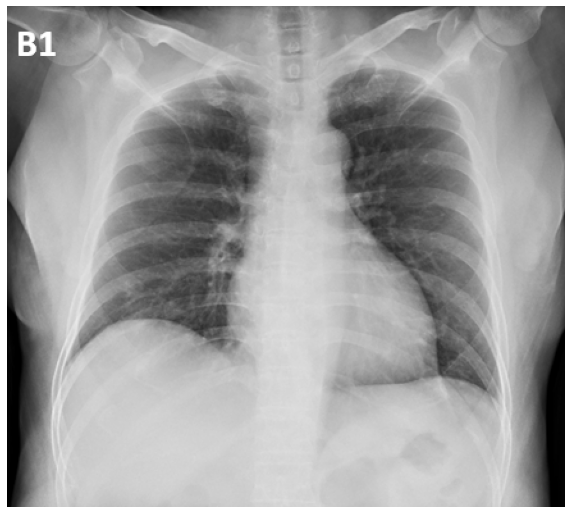

In [0]:
# # preview target image
# img_index = 181818
# img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
# open_image(img_id)

# #check image by url
# img_url = '85E52EB3-56E9-4D67-82DA-DEA247C82886.jpeg'
# additional_cols[additional_cols.images == f'./images/{img_url}']

# very fast query speed, ~5ms
img_index = 178
img_id, img_label, similar_images_df = get_similar_images_annoy(annoy_tree, img_index, number_of_items=36)

print(img_label)
img = open_image(img_id)
img.show(figsize=(10, 10))

In [0]:
similar_images_df = similar_images_df.merge(additional_cols,left_on='img_path',right_on='images',how='left')
similar_images_df.drop(['images'], axis=1)

img_path  ... survival
0   ./images/2C10A413-AABE-4807-8CCE-6A2025594067....  ...      NaN
1   ./images/1312A392-67A3-4EBF-9319-810CF6DA5EF6....  ...      NaN
2                  ./images/covid-19-pneumonia-12.jpg  ...      NaN
3                   ./images/jkms-35-e79-g001-l-b.jpg  ...        Y
4   ./images/35AF5C3B-D04D-4B4B-92B7-CB1F67D83085....  ...        Y
5                   ./images/jkms-35-e79-g001-l-a.jpg  ...        Y
6   ./images/D5ACAA93-C779-4E22-ADFA-6A220489F840....  ...        Y
7   ./images/E1724330-1866-4581-8CD8-CEC9B8AFEDDE....  ...      NaN
8   ./images/F63AB6CE-1968-4154-A70F-913AF154F53D....  ...      NaN
9   ./images/5CBC2E94-D358-401E-8928-965CCD965C5C....  ...      NaN
10  ./images/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87....  ...      NaN
11                   ./images/kjr-21-e24-g002-l-a.jpg  ...      NaN
12  ./images/7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png  ...      NaN
13  ./images/1-s2.0-S1684118220300608-main.pdf-002...  ...        Y
14  ./images/1-s2.0-S1684118220300682-main.pdf-003...  ...        Y
15     ./images/nCoV-radiol.2020200269.fig1-day7.jpeg  ...        Y
16                 ./images/all14238-fig-0001-m-c.jpg  ...        Y
17                 ./images/all14238-fig-0001-m-b.jpg  ...        Y
18                ./images/covid-19-pneumonia-7-L.jpg  ...      NaN
19                 ./images/covid-19-pneumonia-19.jpg  ...      NaN
20  ./images/23E99E2E-447C-46E5-8EB2-D35D12473C39.png  ...      NaN
21    ./images/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  ...        Y
22                 ./images/all14238-fig-0002-m-e.jpg  ...        N
23  ./images/93FE0BB1-022D-4F24-9727-987A07975FFB....  ...      NaN
24  ./images/E63574A7-4188-4C8D-8D17-9D67A18A1AFA....  ...        Y
25    ./images/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  ...        Y
26                ./images/ryct.2020200028.fig1a.jpeg  ...        Y
27  ./images/254B82FC-817D-4E2F-AB6E-1351341F0E38....  ...      NaN
28  ./images/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C....  ...      NaN
29  ./images/7E335538-2F86-424E-A0AB-6397783A38D0....  ...      NaN
30  ./images/4C4DEFD8-F55D-4588-AAD6-C59017F55966....  ...      NaN
31                 ./images/NORMAL2-IM-0911-0001.jpeg  ...      NaN
32  ./images/31BA3780-2323-493F-8AED-62081B9C383B....  ...      NaN
33  ./images/F2DE909F-E19C-4900-92F5-8F435B031AC6....  ...      NaN
34  ./images/F4341CE7-73C9-45C6-99C8-8567A5484B63....  ...        Y
35                   ./images/kjr-21-e24-g001-l-a.jpg  ...      NaN

[36 rows x 7 columns]

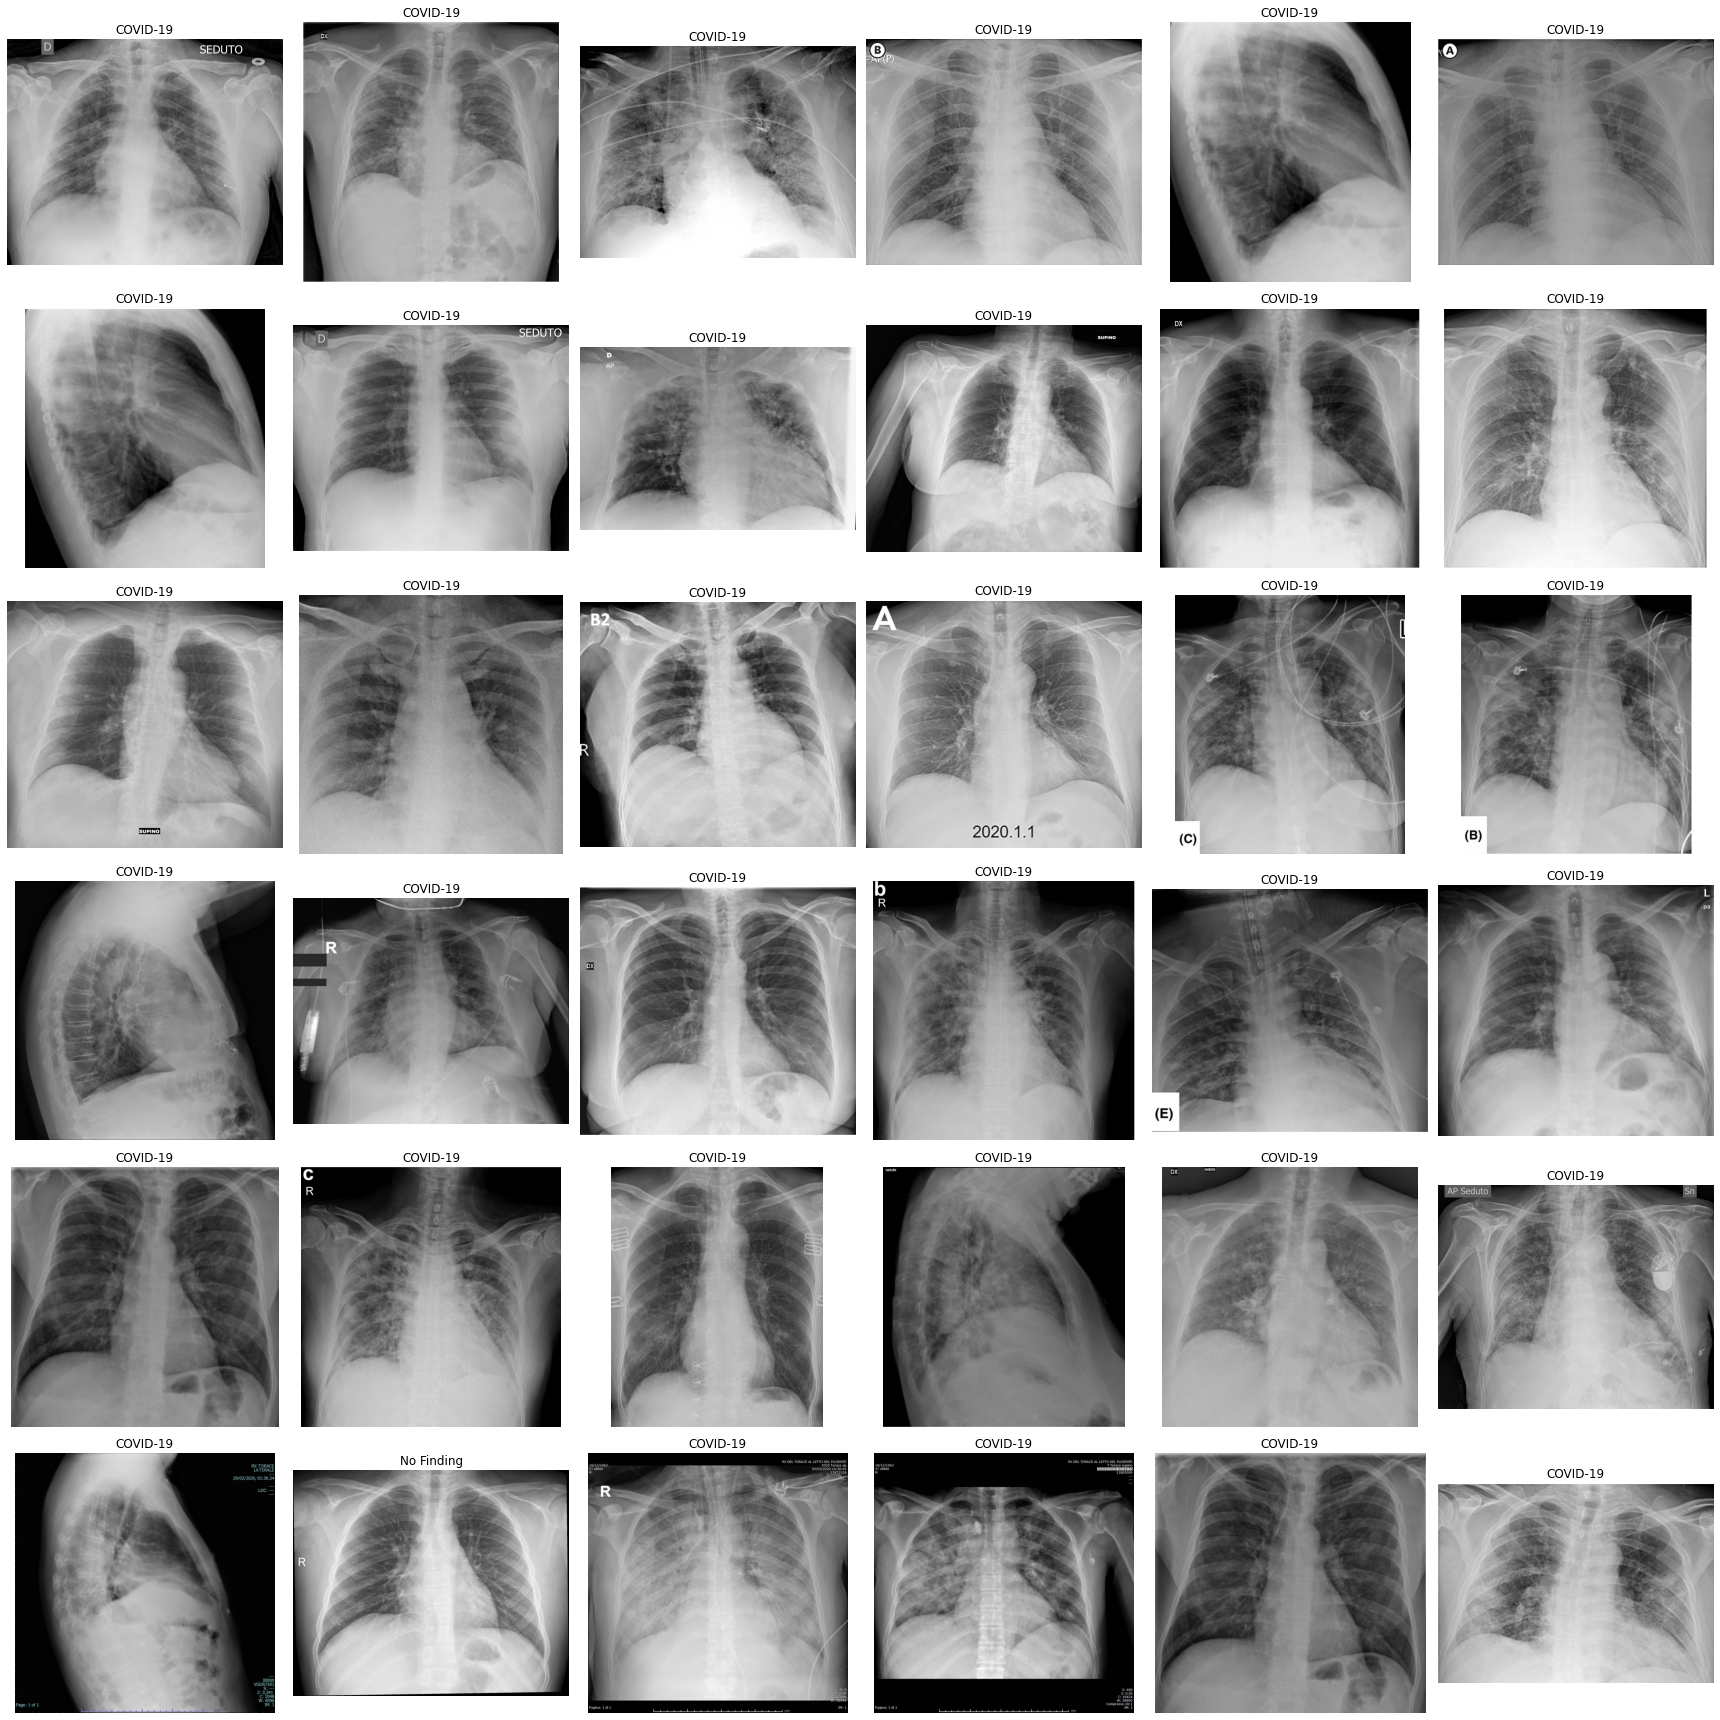

In [0]:
show_similar_images(similar_images_df)

2.755403518676758 ms
COVID-19


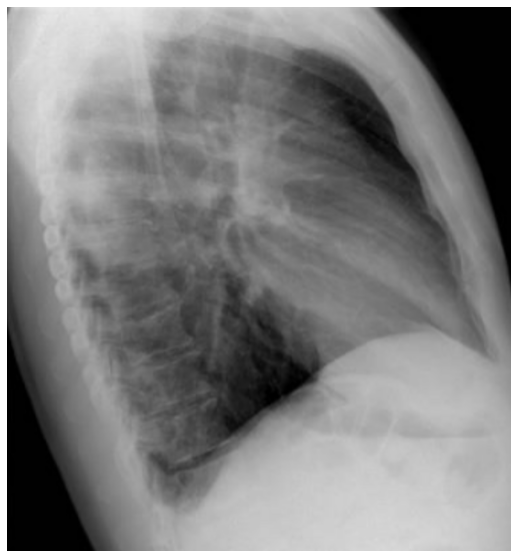

In [0]:
img_index = 989
img_id, img_label, similar_images_df = get_similar_images_annoy(annoy_tree, img_index, number_of_items=36)

print(img_label)
img = open_image(img_id)
img.show(figsize=(10, 10))

In [0]:
similar_images_df = similar_images_df.merge(additional_cols,left_on='img_path',right_on='images',how='left')
similar_images_df.drop(['images'], axis=1)

img_path  ... survival
0   ./images/D5ACAA93-C779-4E22-ADFA-6A220489F840....  ...        Y
1   ./images/F63AB6CE-1968-4154-A70F-913AF154F53D....  ...      NaN
2                   ./images/jkms-35-e79-g001-l-a.jpg  ...        Y
3   ./images/2C10A413-AABE-4807-8CCE-6A2025594067....  ...      NaN
4   ./images/23E99E2E-447C-46E5-8EB2-D35D12473C39.png  ...      NaN
5   ./images/E63574A7-4188-4C8D-8D17-9D67A18A1AFA....  ...        Y
6   ./images/1-s2.0-S1684118220300608-main.pdf-002...  ...        Y
7   ./images/7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png  ...      NaN
8   ./images/1312A392-67A3-4EBF-9319-810CF6DA5EF6....  ...      NaN
9                  ./images/covid-19-pneumonia-12.jpg  ...      NaN
10                ./images/ryct.2020200028.fig1a.jpeg  ...        Y
11  ./images/1-s2.0-S1684118220300682-main.pdf-003...  ...        Y
12                   ./images/kjr-21-e24-g002-l-a.jpg  ...      NaN
13  ./images/F4341CE7-73C9-45C6-99C8-8567A5484B63....  ...        Y
14                ./images/covid-19-pneumonia-7-L.jpg  ...      NaN
15                 ./images/all14238-fig-0001-m-b.jpg  ...        Y
16  ./images/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87....  ...      NaN
17                 ./images/all14238-fig-0002-m-e.jpg  ...        N
18                 ./images/all14238-fig-0001-m-c.jpg  ...        Y
19  ./images/5931B64A-7B97-485D-BE60-3F1EA76BC4F0....  ...        Y
20     ./images/nCoV-radiol.2020200269.fig1-day7.jpeg  ...        Y
21                  ./images/jkms-35-e79-g001-l-b.jpg  ...        Y
22                 ./images/covid-19-pneumonia-19.jpg  ...      NaN
23  ./images/5CBC2E94-D358-401E-8928-965CCD965C5C....  ...      NaN
24  ./images/E1724330-1866-4581-8CD8-CEC9B8AFEDDE....  ...      NaN
25    ./images/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  ...        Y
26  ./images/93FE0BB1-022D-4F24-9727-987A07975FFB....  ...      NaN
27  ./images/1-s2.0-S1684118220300682-main.pdf-003...  ...        Y
28  ./images/1-s2.0-S1684118220300608-main.pdf-001...  ...        Y
29    ./images/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  ...        Y
30                   ./images/kjr-21-e24-g001-l-a.jpg  ...      NaN
31  ./images/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C....  ...      NaN
32                 ./images/NORMAL2-IM-0771-0001.jpeg  ...      NaN
33  ./images/F2DE909F-E19C-4900-92F5-8F435B031AC6....  ...      NaN
34  ./images/254B82FC-817D-4E2F-AB6E-1351341F0E38....  ...      NaN
35                         ./images/IM-0022-0001.jpeg  ...      NaN

[36 rows x 7 columns]

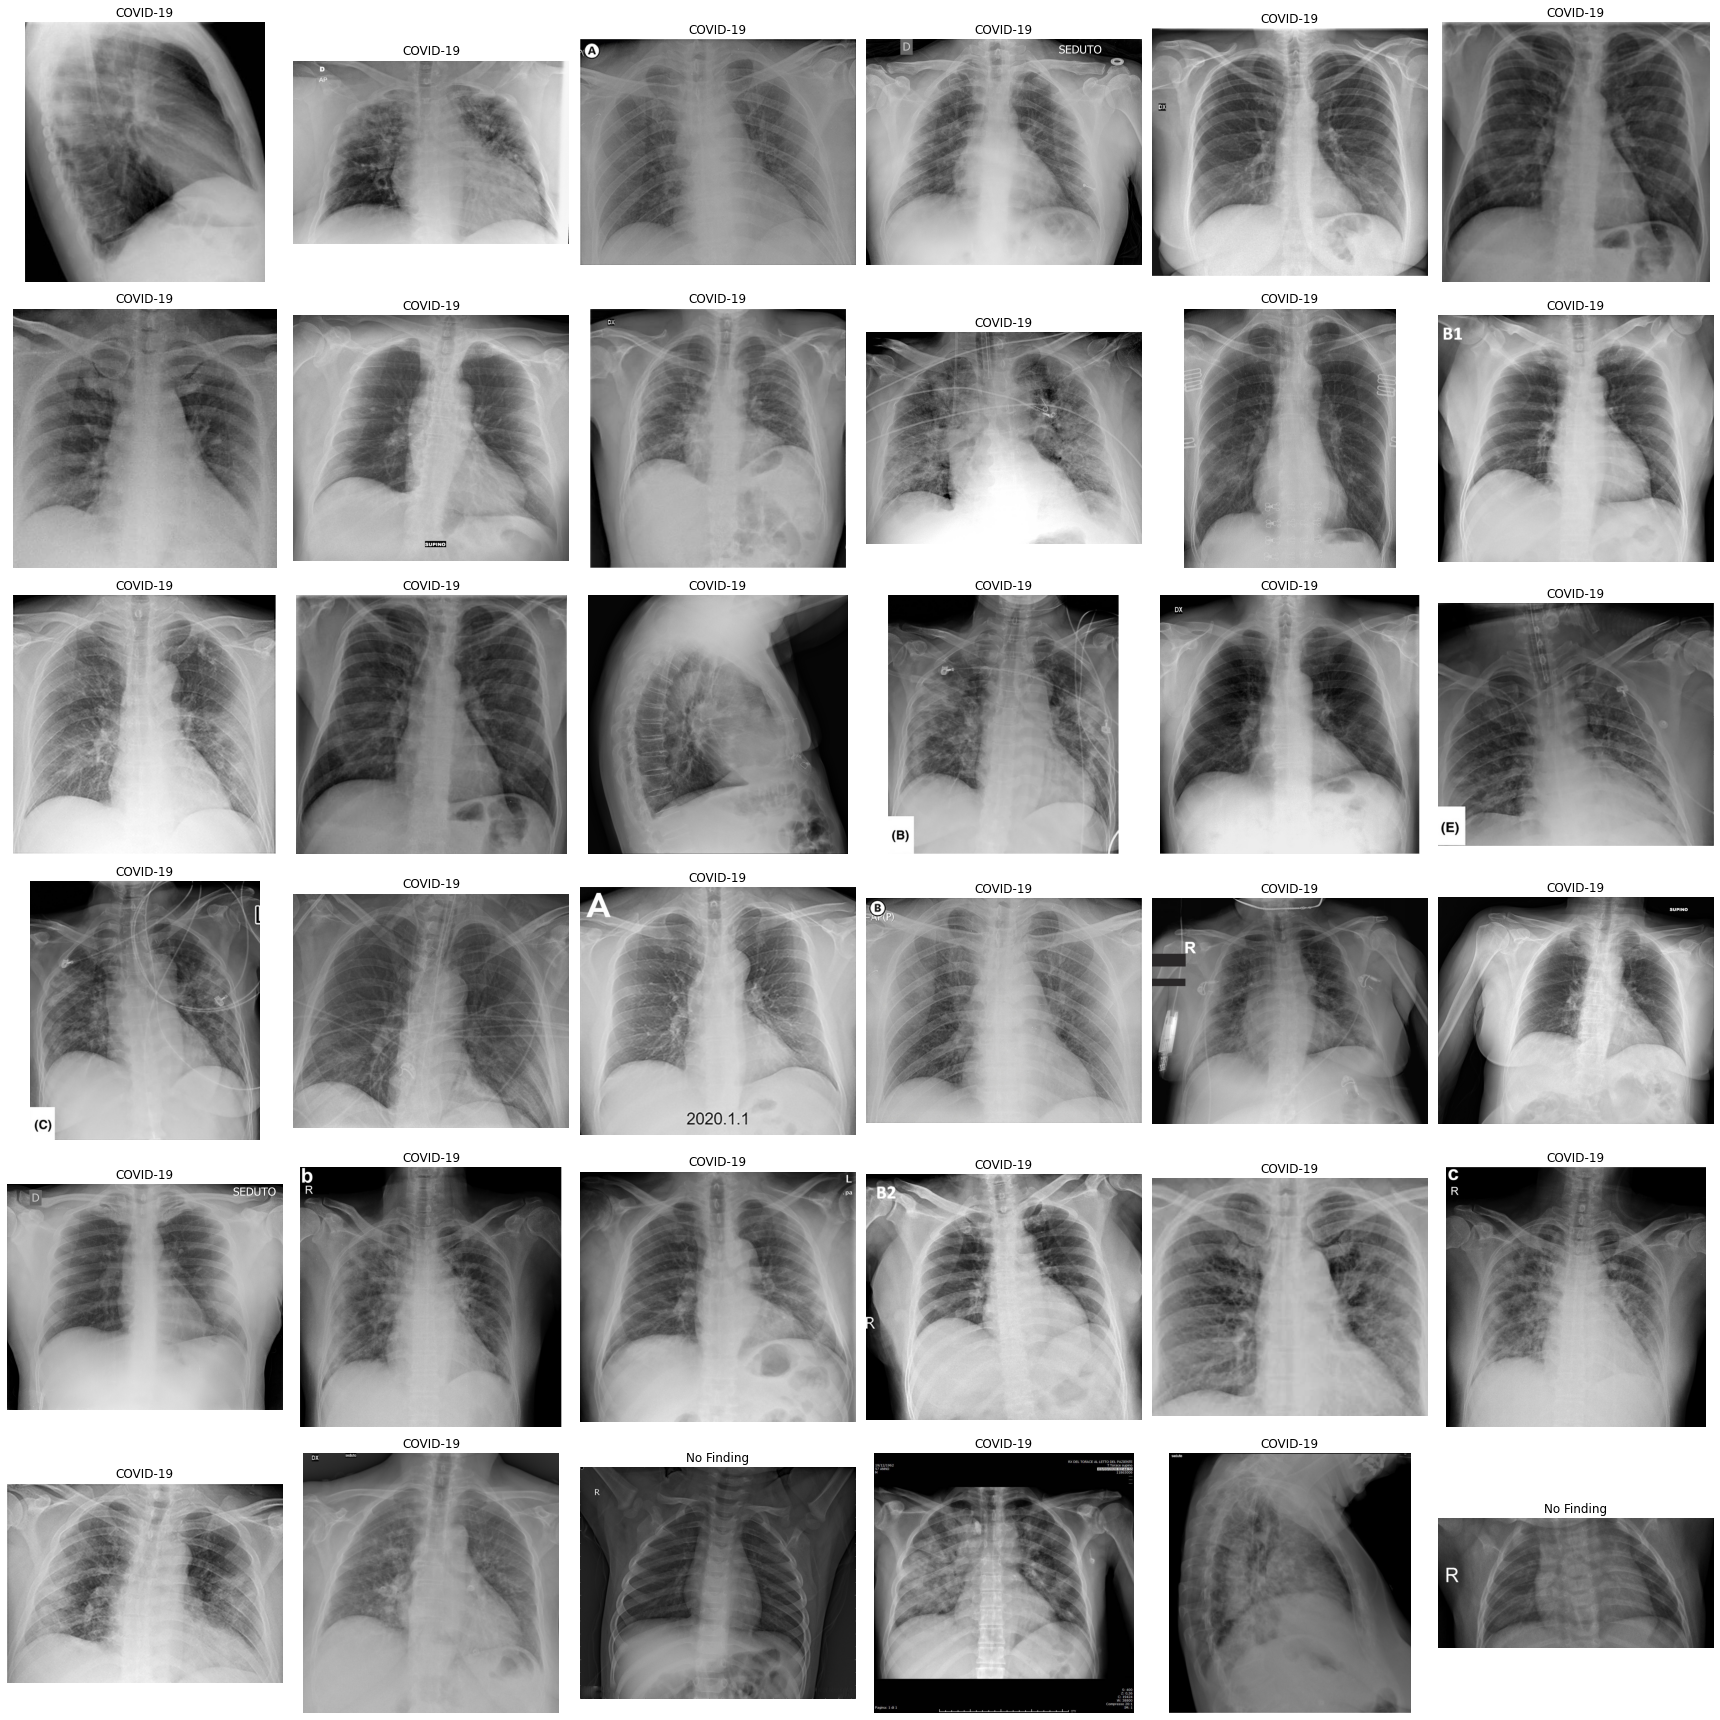

In [0]:
show_similar_images(similar_images_df)

1.140594482421875 ms
No Finding


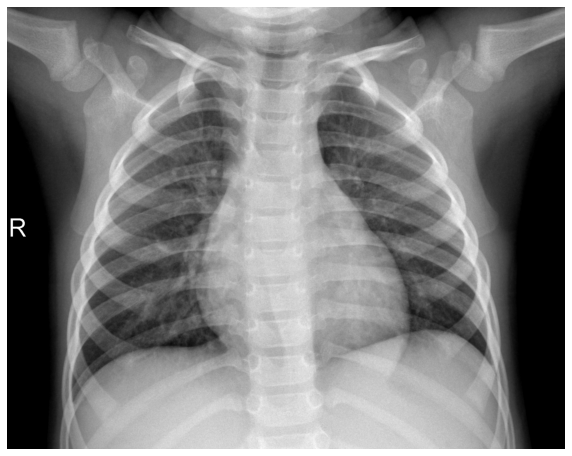

In [0]:
img_id, img_label, similar_images_df = get_similar_images_annoy(annoy_tree, 33, number_of_items=36)

print(img_label)
img = open_image(img_id)
img.show(figsize=(10, 10))

In [0]:
similar_images_df = similar_images_df.merge(additional_cols,left_on='img_path',right_on='images',how='left')
similar_images_df.drop(['images'], axis=1)

img_path       label  ...  location survival
0                ./images/IM-0421-0001.jpeg  No Finding  ...       NaN      NaN
1        ./images/NORMAL2-IM-1144-0001.jpeg  No Finding  ...       NaN      NaN
2        ./images/NORMAL2-IM-1020-0001.jpeg  No Finding  ...       NaN      NaN
3                ./images/IM-0353-0001.jpeg  No Finding  ...       NaN      NaN
4                ./images/IM-0111-0001.jpeg  No Finding  ...       NaN      NaN
5        ./images/NORMAL2-IM-1122-0001.jpeg  No Finding  ...       NaN      NaN
6        ./images/NORMAL2-IM-1170-0001.jpeg  No Finding  ...       NaN      NaN
7                ./images/IM-0694-0001.jpeg  No Finding  ...       NaN      NaN
8        ./images/NORMAL2-IM-0975-0001.jpeg  No Finding  ...       NaN      NaN
9        ./images/NORMAL2-IM-0337-0001.jpeg  No Finding  ...       NaN      NaN
10       ./images/NORMAL2-IM-0868-0001.jpeg  No Finding  ...       NaN      NaN
11               ./images/IM-0162-0001.jpeg  No Finding  ...       NaN      NaN
12               ./images/IM-0103-0001.jpeg  No Finding  ...       NaN      NaN
13          ./images/IM-0650-0001-0001.jpeg  No Finding  ...       NaN      NaN
14  ./images/NORMAL2-IM-1020-0001-0001.jpeg  No Finding  ...       NaN      NaN
15               ./images/IM-0257-0001.jpeg  No Finding  ...       NaN      NaN
16               ./images/IM-0292-0001.jpeg  No Finding  ...       NaN      NaN
17               ./images/IM-0446-0001.jpeg  No Finding  ...       NaN      NaN
18          ./images/IM-0608-0001-0002.jpeg  No Finding  ...       NaN      NaN
19       ./images/NORMAL2-IM-0960-0001.jpeg  No Finding  ...       NaN      NaN
20       ./images/NORMAL2-IM-0993-0001.jpeg  No Finding  ...       NaN      NaN
21       ./images/NORMAL2-IM-1134-0001.jpeg  No Finding  ...       NaN      NaN
22       ./images/NORMAL2-IM-1196-0001.jpeg  No Finding  ...       NaN      NaN
23       ./images/NORMAL2-IM-0399-0001.jpeg  No Finding  ...       NaN      NaN
24               ./images/IM-0604-0001.jpeg  No Finding  ...       NaN      NaN
25               ./images/IM-0577-0001.jpeg  No Finding  ...       NaN      NaN
26       ./images/NORMAL2-IM-1234-0001.jpeg  No Finding  ...       NaN      NaN
27               ./images/IM-0673-0001.jpeg  No Finding  ...       NaN      NaN
28       ./images/NORMAL2-IM-0561-0001.jpeg  No Finding  ...       NaN      NaN
29       ./images/NORMAL2-IM-0939-0001.jpeg  No Finding  ...       NaN      NaN

[30 rows x 7 columns]

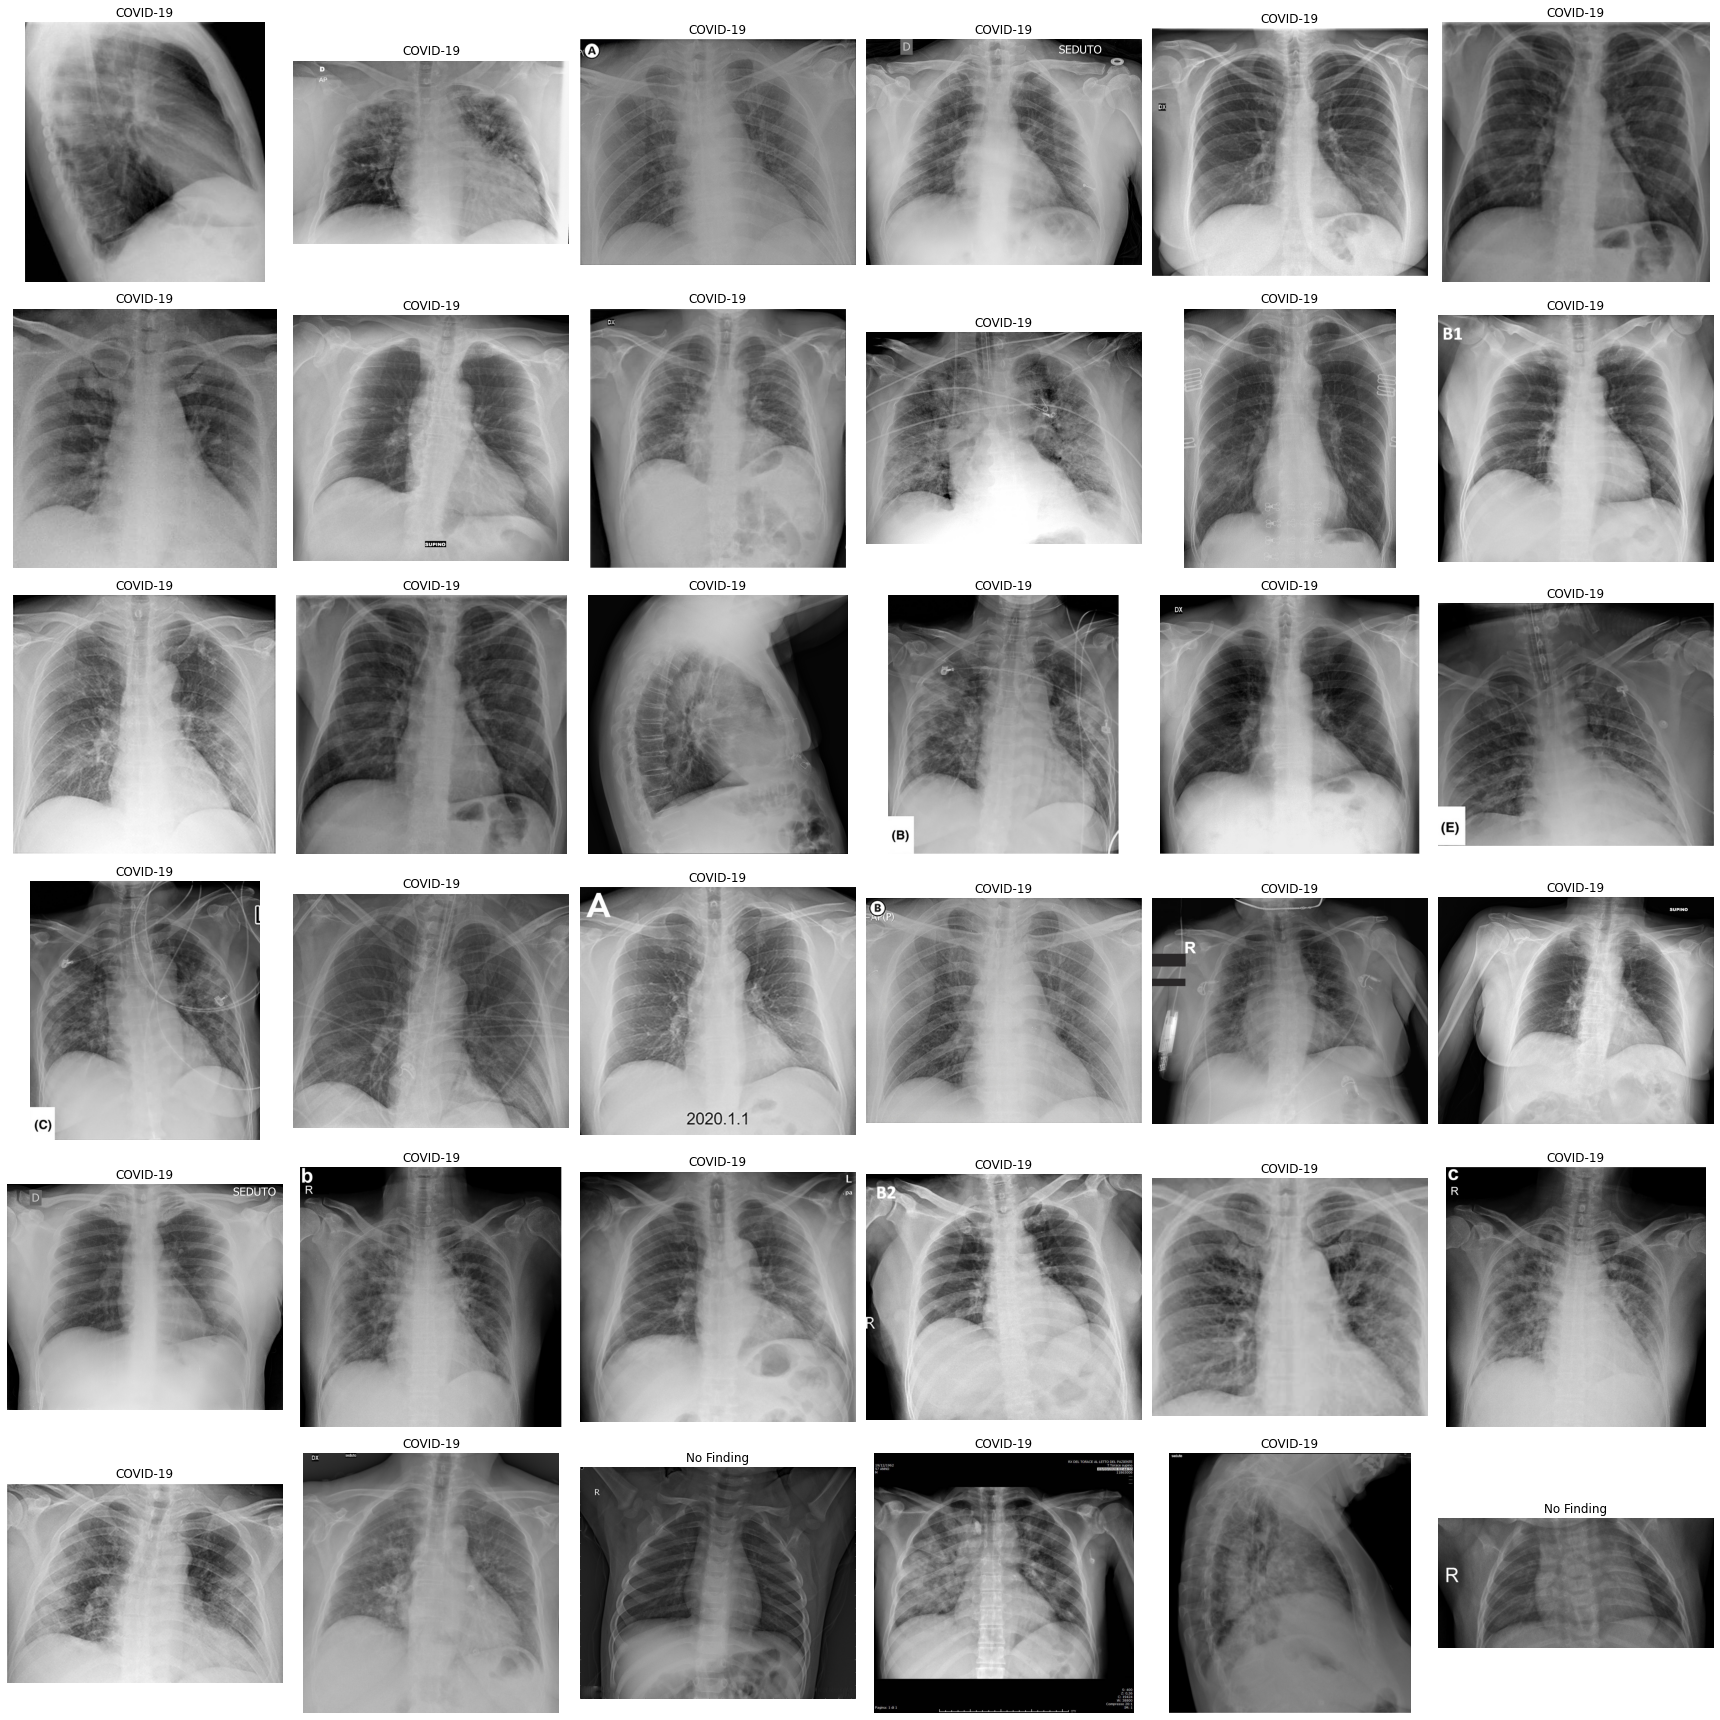

In [0]:
show_similar_images(similar_images_df)



* We observe that some items are easier to recommend, for example this stripped sweater.
* White jeans are a little harder, we seem to end with up leggings, black pants and blue jeans
* While the interesting outfit results in very diverse set of recommendations. It seems that this method is not very good in matching complex colors, layers, and outfits.





# Reflections

*  For Annoy, test with different number of trees and distance metrics. Do you observe any difference in terms of speed and items returned? 
*  For Annoy, test with different target images. Are the recommendations "good"? How can the recommendations be improved? 
* What happens if we swap out the pretrained_model to resnet152? What will you expect from running a "more accurate" model?
* Will we be able to apply this entire workflow on different images? For example covid-19 x-ray images?



